In [1]:
import json
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [2]:
# project_dir = "C:\\Users\\tilenkopac\\Projects\\genome-embedding"
# dataset_dir = os.path.join(project_dir, "data", "bacteria_661k_assemblies_balanced_small")
project_dir = "/d/hpc/home/tcurk/tkopac/genome-embedding"
dataset_dir = os.path.join(project_dir, "data", "deepmicrobes_mag_reads")

In [8]:
n_embeddings = 0
with open(os.path.join(dataset_dir, "embeddings", "661k_conv_small_elu_loc_pres_ld10_ws100_take_2", "no-sampler", "val.csv"), "rt") as file:
    for _ in tqdm(file, desc="Counting embeddings"):
        n_embeddings += 1

Counting embeddings: 0it [00:00, ?it/s]

In [44]:
def analyse_autoencoder_embeddings(autoencoder_name, sampler_name):
    # read embeddings
    embeddings = []

    with open(os.path.join(dataset_dir, "embeddings", autoencoder_name, sampler_name, f"test.csv"), "rt") as file:

        # prepare latent value counters
        _, embedding_str = file.readline().strip().split(";")
        embedding = json.loads(embedding_str)
        latent_element_counters = [Counter() for _ in range(len(embedding))]
        latent_vector_counter = Counter()
        file.seek(0)

        # count rounded latent values
        # c = 0
        for line in tqdm(file, total=n_embeddings, desc=f"Reading embeddings of \"{autoencoder_name}\" + \"{sampler_name}\""):
            _, embedding_str = line.strip().split(";")
            embedding = json.loads(embedding_str)
            rounded = [round(value, 2) for value in embedding]
            latent_vector_counter.update({str(rounded): 1})
            for i, value in enumerate(rounded):
               latent_element_counters[i].update([round(value, 2)])

            # c += 1
            # if c == 10000:
            #     break

    # draw latent value distributions
    n_cols = 5
    fig, axes = plt.subplots(int(np.ceil(len(latent_element_counters) / n_cols)), n_cols, figsize=(12, 6))
    fig.suptitle(autoencoder_name, fontsize=14)
    for i, counter in enumerate(latent_element_counters):
        row = np.where(np.arange(0, len(latent_element_counters), n_cols) <= i)[0][-1]
        column = i % n_cols
        sorted_items = sorted(counter.items())
        sorted_keys = [k for k, _ in sorted_items]
        sorted_values = [v for _, v in sorted_items]
        axes[row][column].bar(sorted_keys, sorted_values, width=0.02)
    fig.tight_layout()

    # print most common latent vectors
    n_vectors_to_print = 10
    print(f"{n_vectors_to_print} most common latent vectors:")
    for vector, count in latent_vector_counter.most_common(n_vectors_to_print):
        print(f"\t• {vector}: {count} ({count / sum(latent_vector_counter.values()) * 100:.4f} %)")

    return embeddings

Reading embeddings of "661k_conv_small_loc_pres_ld10_ws100" + "no-sampler":   0%|          | 0/5100000 [00:00<…

10 most common latent vectors:
	• [0.52, 0.73, 0.67, 0.43, 0.47, 1.02, 0.38, 0.37, 0.59, 0.51]: 6 (0.0001 %)
	• [0.61, 0.63, 0.71, 0.48, 0.24, 1.15, 0.56, 0.26, 0.55, 0.23]: 6 (0.0001 %)
	• [0.31, 0.25, 0.77, 0.5, 0.51, 0.86, 0.8, 0.48, 0.61, 0.5]: 5 (0.0001 %)
	• [0.39, 0.65, 0.46, 0.44, 0.55, 0.86, 0.73, 0.29, 0.81, 0.71]: 5 (0.0001 %)
	• [0.48, 0.68, 0.52, 0.52, 0.35, 1.09, 0.66, 0.23, 0.63, 0.35]: 5 (0.0001 %)
	• [0.45, 0.54, 0.31, 0.55, 0.65, 1.01, 0.93, 0.21, 0.53, 0.4]: 5 (0.0001 %)
	• [0.79, 0.66, 0.6, 0.32, 0.78, 0.61, 0.52, 0.44, 0.47, 0.76]: 4 (0.0001 %)
	• [0.41, 0.46, 0.95, 0.37, 0.7, 0.8, 0.48, 0.35, 0.77, 0.5]: 4 (0.0001 %)
	• [0.61, 0.33, 0.75, 0.38, 0.33, 0.93, 0.68, 0.56, 0.4, 0.53]: 4 (0.0001 %)
	• [0.54, 0.4, 0.69, 0.51, 0.71, 0.93, 0.47, 0.61, 0.38, 0.41]: 4 (0.0001 %)


Reading embeddings of "661k_conv_small_elu_loc_pres_ld10_ws100_take_2" + "no-sampler":   0%|          | 0/5100…

10 most common latent vectors:
	• [0.29, 0.37, 0.39, 0.09, 0.14, 0.5, 0.19, 0.29, 0.17, 0.32]: 6 (0.0001 %)
	• [0.48, 0.28, 0.39, 0.37, 0.49, 0.34, 0.56, 0.25, 0.5, 0.29]: 6 (0.0001 %)
	• [0.41, 0.42, 0.15, 0.32, 0.19, 0.41, 0.44, 0.38, 0.33, 0.2]: 5 (0.0001 %)
	• [0.33, 0.41, 0.31, 0.18, 0.29, 0.41, 0.32, 0.28, 0.31, 0.25]: 5 (0.0001 %)
	• [0.21, 0.43, 0.5, 0.27, 0.42, 0.54, 0.35, 0.24, 0.57, 0.35]: 5 (0.0001 %)
	• [0.37, 0.4, 0.41, 0.12, 0.51, 0.47, 0.22, 0.17, 0.33, 0.22]: 5 (0.0001 %)
	• [0.49, 0.37, 0.28, 0.31, 0.49, 0.41, 0.05, 0.22, 0.45, 0.5]: 5 (0.0001 %)
	• [0.29, 0.22, 0.38, 0.05, 0.4, 0.27, 0.34, 0.43, 0.25, 0.27]: 4 (0.0001 %)
	• [0.21, 0.2, 0.59, 0.1, 0.21, 0.38, 0.31, 0.3, 0.12, 0.32]: 4 (0.0001 %)
	• [0.31, 0.24, 0.35, 0.41, 0.33, 0.27, 0.49, 0.26, 0.37, 0.12]: 4 (0.0001 %)


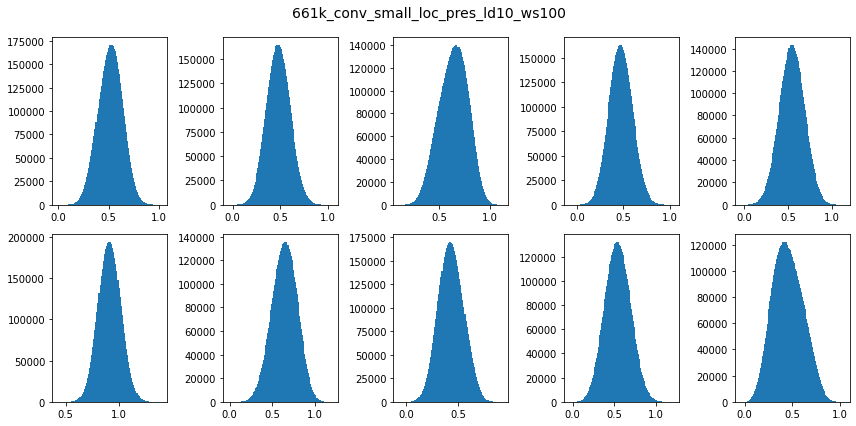

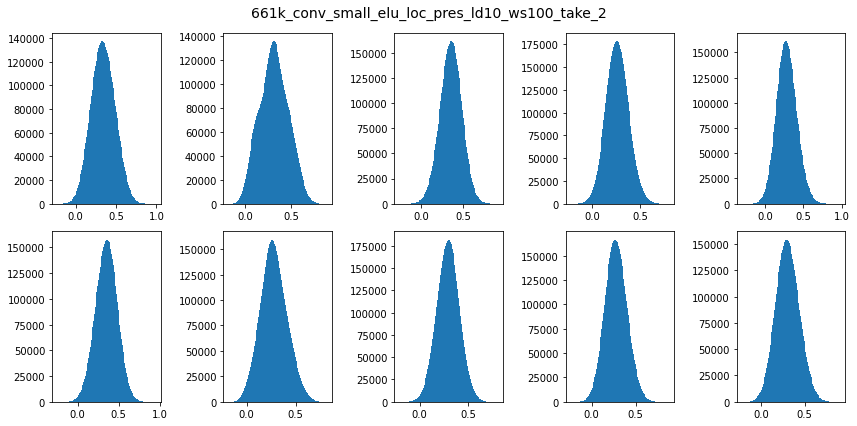

In [45]:
# autoencoder_names = [
#     "PARAMETER_TESTING_661k_conv_small_relu",
#     "PARAMETER_TESTING_661k_conv_small_relu_rec_only",
#     "PARAMETER_TESTING_661k_conv_small_elu",
#     "PARAMETER_TESTING_661k_conv_small_elu_rec_only",
#     "PARAMETER_TESTING_661k_conv_small_elu_argmax_activation",
#     "PARAMETER_TESTING_661k_conv_small_elu_rec_only_argmax_activation"
# ]
autoencoder_names = [
    "661k_conv_small_loc_pres_ld10_ws100",
    "661k_conv_small_elu_loc_pres_ld10_ws100_take_2"
]
for name in autoencoder_names:
    analyse_autoencoder_embeddings(name, "no-sampler")